In [57]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

### Load data and visualize some rows

In [58]:
graph = pd.read_csv('q1_data.csv', index_col=0)
graph.head(3)

,Mexico City,Sofia,Caracas,Paris,Oslo,Panama,Riga,Hanoi,Athens,Luxembourg,...,Santo Domingo,London,Andorra la Vella,Yerevan,Madrid,Amsterdam,Copenhagen,Lima,Vilnius,Warsaw
Mexico City,0.000000,10943.249595,3597.018894,9196.121646,9195.632410,2407.509542,10027.336535,14759.958516,11280.399674,9417.091543,...,3062.375170,8928.820398,9393.135021,12392.218540,9062.613574,9215.541204,9509.162920,4255.032976,10240.684649,10180.162850
Sofia,10943.249595,0.000000,9235.562797,1757.561532,2096.229362,10360.411414,1585.325302,7847.187565,525.673837,1526.175436,...,8887.495567,2014.605290,1779.664110,1783.484275,2253.345327,1744.422812,1637.012112,11753.661475,1340.976711,1073.949136
Caracas,3597.018894,9235.562797,0.000000,7616.652180,8311.079762,1395.108255,9091.109074,16421.894156,9343.995782,7899.810067,...,951.601568,7496.409509,7456.263338,11009.217933,6992.114712,7851.614143,8385.224076,2744.751040,9195.400241,8944.692095


### Plot graph

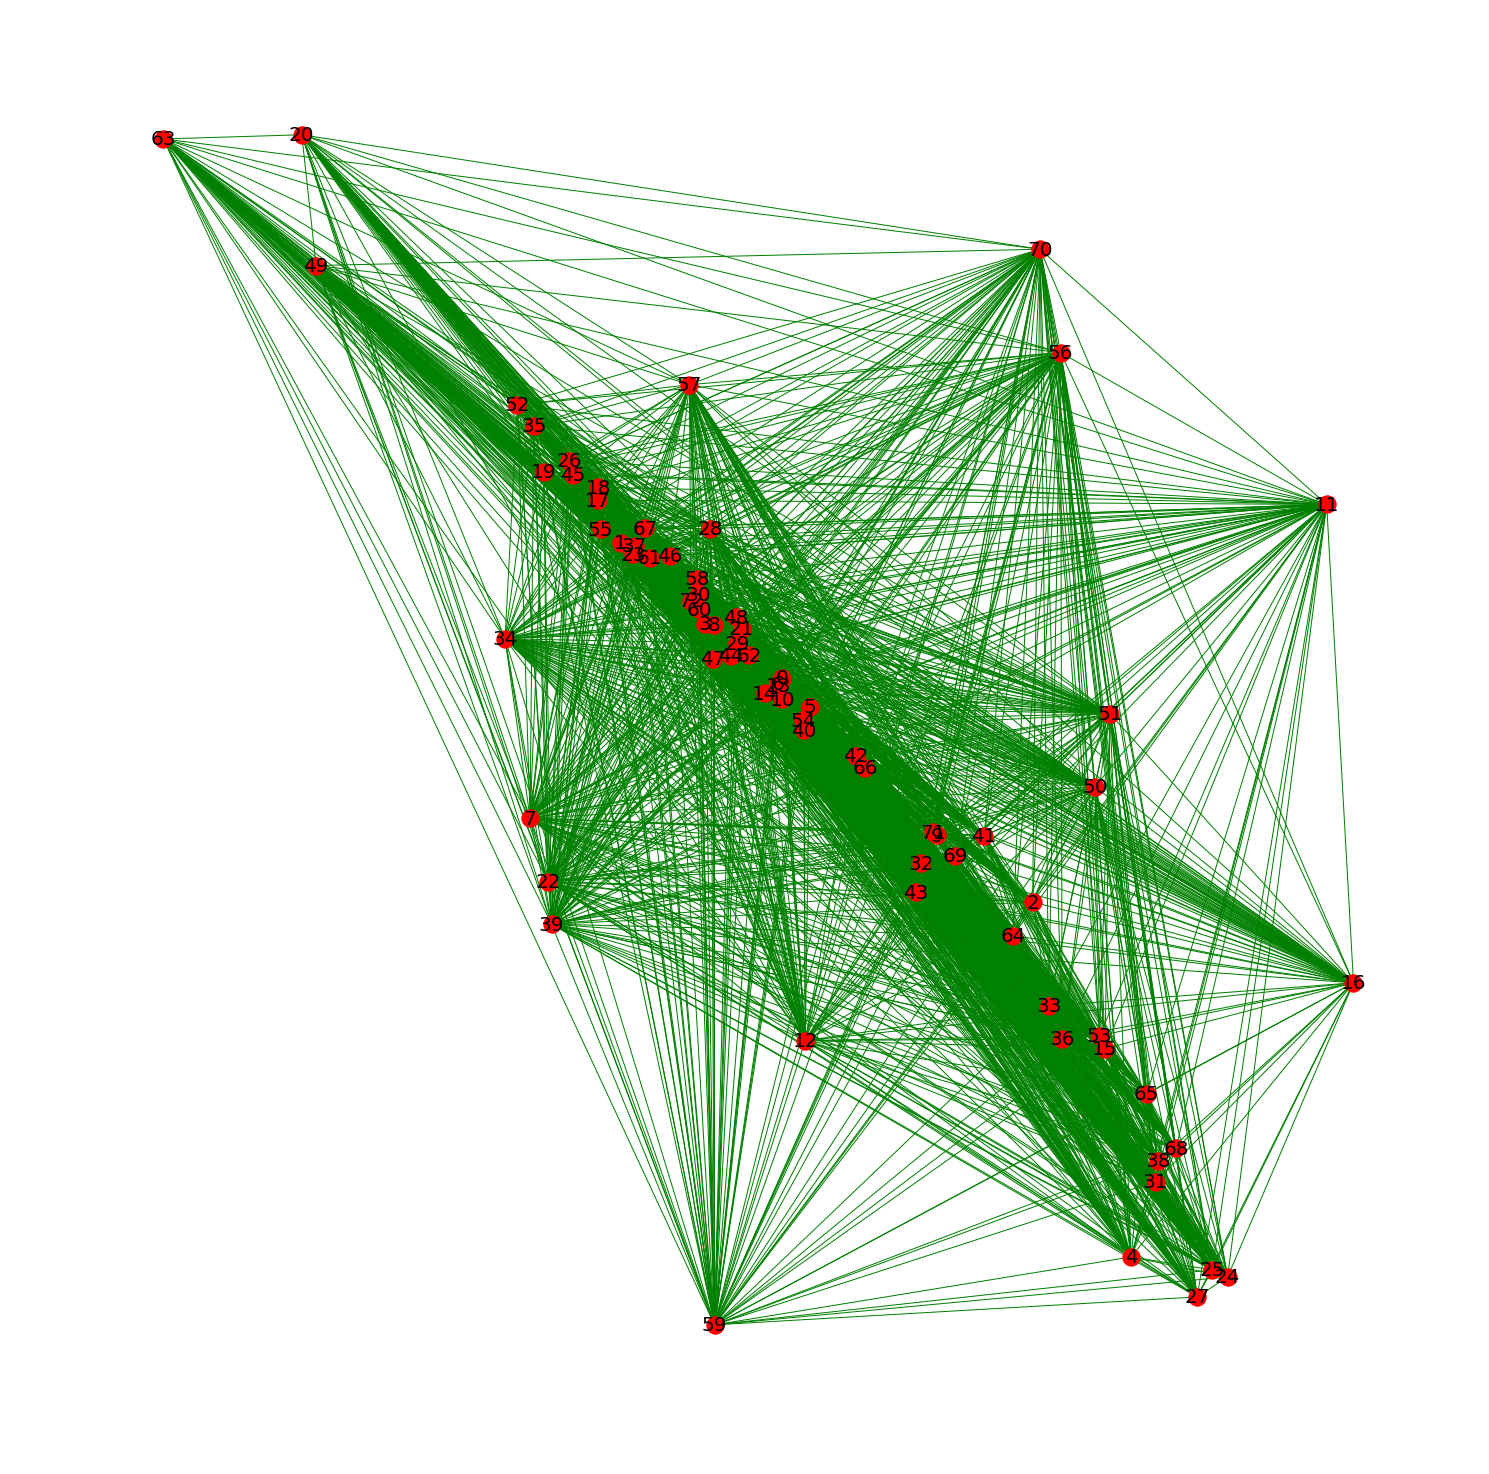

In [59]:
G = nx.from_numpy_matrix(graph.values)
nx.draw(G, with_labels=True, font_size=20, edge_color='g')
labels = nx.get_edge_attributes(G,'weight')
plt.draw()

In this case, the graph is not really useful since points are in a 3D coodinate system but we are
projecting them onto a 2D space.

### Function to find shortest node from current

Given the position of a node, and the visited nodes, we will decide the next move based on the shortest
distance in the graph.

In [60]:
def find_shortest_node(cur, visited, graph):
    distances = graph.sort_values()
    i = 0
    while distances.index[i] in visited:
        i += 1
    return distances.index[i], graph.loc[distances.index[i]]

### Distance-based method

In [61]:
city2node = {i: ind for ind,i in enumerate(graph.columns)}
node2city = {ind:i for ind,i in enumerate(graph.columns)}
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8
graph.columns = range(len(graph.columns))
graph.index = range(len(graph.columns))

In [62]:
while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 2350.3072558947 kmph
Oslo -> Amsterdam -> Brussels -> Luxembourg -> Bern -> Madrid -> Ottawa -> Mexico City -> Santiago
Tallinn -> Kiev -> Yerevan -> Baku -> Tehran -> Ashgabat -> Tashkent -> Kabul -> Hanoi -> Taipei
Stockholm -> Warsaw -> Budapest -> Sarajevo -> Valletta -> Pretoria -> Montevideo
Riga -> Belgrade -> Skopje -> Athens -> Colombo -> Jakarta -> Canberra -> Wellington
Moscow -> Ankara -> Nicosia -> Damascus -> New Delhi -> Bangkok -> Manila
Copenhagen -> Berlin -> Prague -> Ljubljana -> Zagreb -> Rome -> Santo Domingo -> Caracas -> Bogota -> Quito -> Lima -> Sucre -> Asuncion -> Buenos Aires
Vilnius -> Bucharest -> Sofia -> Cairo -> Beijing -> Seoul -> Tokyo
Dublin -> London -> Paris -> Andorra la Vella -> Lisbon -> Washington -> Tegucigalpa -> San Jose -> Panama -> Brasilia


### Zone-based method

An interesting idea could be the following: divide the map in 8 zones and send each reindeer to one different zone in the first move.

#### Divide map in clusters

In [63]:
from kmedoids import kMedoids
M, C = kMedoids(graph.values, k=8)
for i in C:
    print("{}: {}".format(i,list(map(lambda x: node2city[x],C[i]))))

0: ['Sofia', 'Athens', 'Damascus', 'Nicosia', 'Ankara', 'Skopje', 'Valletta', 'Cairo']
1: ['Paris', 'Oslo', 'Luxembourg', 'Berlin', 'North Pole', 'Brussels', 'Dublin', 'Stockholm', 'Bern', 'London', 'Amsterdam', 'Copenhagen']
2: ['Hanoi', 'Bangkok', 'Manila', 'Seoul', 'Beijing', 'Tokyo', 'Jakarta', 'Wellington', 'Canberra', 'Taipei']
3: ['Mexico City', 'Caracas', 'Panama', 'Montevideo', 'Tegucigalpa', 'Santiago', 'Buenos Aires', 'Brasilia', 'Asuncion', 'Sucre', 'San Jose', 'Ottawa', 'Quito', 'Bogota', 'Washington', 'Santo Domingo', 'Lima']
4: ['Riga', 'Tallinn', 'Ljubljana', 'Kiev', 'Zagreb', 'Moscow', 'Budapest', 'Sarajevo', 'Rome', 'Bucharest', 'Belgrade', 'Prague', 'Vilnius', 'Warsaw']
5: ['Pretoria']
6: ['Kabul', 'Tashkent', 'Tehran', 'Colombo', 'New Delhi', 'Ashgabat', 'Baku', 'Yerevan']
7: ['Lisbon', 'Andorra la Vella', 'Madrid']


#### Distribute reindeers per zones

In the first iteration we send each reindeer to one different zone. Note that we need to reload variables

In [64]:
M, C = kMedoids(graph.values, k=8)
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8

for i in range(8):
    next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
    paths[i].append(node2city[next_node])
    distances[i] += dist
    visited.update({next_node})
    current[i] = next_node

while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 2372.3932987174003 kmph
['Dublin', 'London', 'Brussels', 'Amsterdam', 'Luxembourg', 'Paris', 'Bern', 'Andorra la Vella', 'Madrid', 'Lisbon', 'Brasilia', 'Asuncion', 'Buenos Aires', 'Montevideo', 'Santiago']
['Oslo', 'Stockholm', 'Tallinn', 'Riga', 'Vilnius', 'Warsaw', 'Copenhagen', 'Sucre', 'Lima']
['Beijing', 'Seoul', 'Tokyo', 'Taipei', 'Manila', 'Hanoi', 'Bangkok', 'Jakarta', 'Canberra', 'Wellington']
['Belgrade', 'Sarajevo', 'Skopje', 'Athens', 'Nicosia', 'Cairo', 'Colombo']
['Moscow', 'Kiev', 'Bucharest', 'Sofia', 'Ankara', 'Damascus', 'Yerevan', 'Baku', 'Tehran']
['Tashkent', 'Kabul', 'New Delhi', 'Ashgabat']
['Ottawa', 'Washington', 'Santo Domingo', 'Caracas', 'Bogota', 'Quito', 'Panama', 'San Jose', 'Tegucigalpa', 'Mexico City']
['Berlin', 'Prague', 'Budapest', 'Zagreb', 'Ljubljana', 'Rome', 'Valletta', 'Pretoria']


We have sent the reindeers one to each zone, but after that is possible that they move back to the closest zone to the North Pole, so eventually having the same problem again. One solution is to force the reindeers to move along its assigned zone until completing all nodes in it.

In [65]:
M, C = kMedoids(graph.values, k=8)
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8

for i in range(8):
    next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
    paths[i].append(node2city[next_node])
    distances[i] += dist
    visited.update({next_node})
    current[i] = next_node

while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        if all([v in visited for v in C[i]]):
            next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        else: # finish your zone before helping others
            next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 2087.1260151596007 kmph
['Hanoi', 'Bangkok', 'Jakarta']
['Tallinn', 'Riga', 'Vilnius', 'Warsaw', 'Prague', 'Budapest', 'Zagreb', 'Ljubljana', 'Sarajevo', 'Belgrade', 'Skopje', 'Sofia', 'Bucharest', 'Kiev', 'Moscow', 'Rome', 'Valletta']
['Taipei', 'Manila', 'Canberra']
['Beijing', 'Seoul', 'Tokyo', 'Wellington']
['Tashkent', 'Kabul', 'New Delhi', 'Ashgabat', 'Tehran', 'Colombo']
['Baku', 'Yerevan', 'Ankara', 'Nicosia', 'Damascus', 'Cairo', 'Athens', 'Pretoria']
['Ottawa', 'Washington', 'Santo Domingo', 'Caracas', 'Bogota', 'Quito', 'Panama', 'San Jose', 'Tegucigalpa', 'Mexico City', 'Lima', 'Sucre']
['Oslo', 'Stockholm', 'Copenhagen', 'Berlin', 'Amsterdam', 'Brussels', 'Luxembourg', 'Paris', 'London', 'Dublin', 'Bern', 'Andorra la Vella', 'Madrid', 'Lisbon', 'Brasilia', 'Asuncion', 'Buenos Aires', 'Montevideo', 'Santiago']


### Initialization matters

It is worth pointing out that the clustering algorithm is not deterministic. It depends on its initialization, and in turn, it has an impact on the performance of the next step:
- This can be observed if we execute the last block several times: different results are obtained.
- Also, we can see that in some cases the algorithm crashes. This occurs when the North Pole is assigned a cluster itself. Since we are sending a reindeer to this cluster, but the only single node in it has been visited, the algorithm as it is does not work. 

So hereafter there is the last version of the algorithm taking into account all these considerations.

In [73]:
minval = 4000
graph = pd.read_csv('q1_data.csv', index_col=0)
indNorthPole = [ind for ind,i in enumerate(graph.columns) if i == 'North Pole'][0]
cols = list(range(indNorthPole)) + list(range(indNorthPole+1, len(graph))) + [indNorthPole]
graph = graph.iloc[cols,cols]
city2node = {i: ind for ind,i in enumerate(graph.columns)}
node2city = {ind:i for ind,i in enumerate(graph.columns)}
graph.columns = range(len(graph))
graph.index = range(len(graph))

for it in range(1,200):
    M, C = kMedoids(graph.iloc[:-1,:-1].values, k=8)
    current = {i: city2node['North Pole'] for i in range(8)}
    visited = {city2node['North Pole']}
    paths = {i : list() for i in range(8)}
    distances = [0] * 8

    for i in range(8):
        next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
        paths[i].append(node2city[next_node])
        distances[i] += dist
        visited.update({next_node})
        current[i] = next_node

    while len(visited) < len(city2node):
        min_travelled = 1000000000
        for i in range(8):
            if all([v in visited for v in C[i]]):
                next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
            else: # finish your zone before helping others
                next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
            if distances[i] + dist < min_travelled:
                min_travelled = distances[i] + dist
                dist_agent = dist
                agent = i
                next_node = next_node_i
        paths[agent].append(node2city[next_node])
        distances[agent] += dist_agent
        visited.update({next_node})
        current[agent] = next_node
    tmp = max(distances)/10
    if tmp < minval:
        minval = tmp
        minpaths = paths
        print(tmp)
        
print('Speed: {} kmph'.format(minval))
for i in minpaths:
    print(' -> '.join(minpaths[i]))

2372.39329872
2223.17795925
1625.70517399
Speed: 1625.705173993 kmph
['Canberra', 'Wellington']
['Budapest', 'Zagreb', 'Ljubljana', 'Sarajevo', 'Belgrade', 'Skopje', 'Sofia', 'Bucharest', 'Athens', 'Ankara', 'Nicosia', 'Damascus', 'Yerevan', 'Baku', 'Tehran', 'Ashgabat']
['Beijing', 'Seoul', 'Tokyo', 'Taipei', 'Manila', 'Hanoi', 'Bangkok', 'Jakarta']
['Dublin', 'London', 'Brussels', 'Amsterdam', 'Luxembourg', 'Paris', 'Madrid', 'Lisbon', 'Brasilia']
['Mexico City', 'Tegucigalpa', 'San Jose', 'Panama', 'Santiago']
['Ottawa', 'Washington', 'Santo Domingo', 'Caracas', 'Bogota', 'Quito', 'Lima', 'Sucre', 'Asuncion', 'Buenos Aires', 'Montevideo']
['Oslo', 'Stockholm', 'Copenhagen', 'Berlin', 'Prague', 'Bern', 'Andorra la Vella', 'Rome', 'Valletta', 'Cairo', 'Pretoria']
['Tallinn', 'Riga', 'Vilnius', 'Warsaw', 'Kiev', 'Moscow', 'Tashkent', 'Kabul', 'New Delhi', 'Colombo']


### Check the solution

Finally, just check the speed required by each reindeer by summing up the distance moved and dividing by the 10 hours they have to distribute the presents.

In [106]:
for i in minpaths:
    distance = 0
    current = city2node['North Pole']
    for j in minpaths[i]:
        distance += graph.loc[current, city2node[j]]
        current = city2node[j]
    print(distance/10)

1153.35693483
1720.09690112
1625.70517399
1480.46545108
1600.72616671
1205.2264646
1582.87191227
1476.92909603
